In [1]:
import numpy as np
import pandas as pd
from os.path import join

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')
import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, fhmm_exact
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 26 days


## Loading data

In [2]:
we = DataSet('/Users/nipunbatra/wikienergy-2.h5')
print('loaded ' + str(len(we.buildings)) + ' buildings')

loaded 239 buildings


In [3]:
building_number = 1
print_dict(we.buildings[building_number].metadata)

In [4]:
elec = we.buildings[building_number].elec
elec.appliances

[Appliance(type='fridge', instance=1),
 Appliance(type='washer dryer', instance=1),
 Appliance(type='dish washer', instance=1),
 Appliance(type='fridge', instance=2),
 Appliance(type='light', instance=1),
 Appliance(type='light', instance=2),
 Appliance(type='electric vehicle', instance=1),
 Appliance(type='electric furnace', instance=1),
 Appliance(type='sockets', instance=1),
 Appliance(type='microwave', instance=1),
 Appliance(type='oven', instance=2),
 Appliance(type='waste disposal unit', instance=1),
 Appliance(type='air conditioner', instance=1),
 Appliance(type='appliance', instance=1),
 Appliance(type='oven', instance=1)]

## Dividing data set into train and test

In [5]:
train = DataSet('/Users/nipunbatra/wikienergy-2.h5')
test = DataSet('/Users/nipunbatra/wikienergy-2.h5')

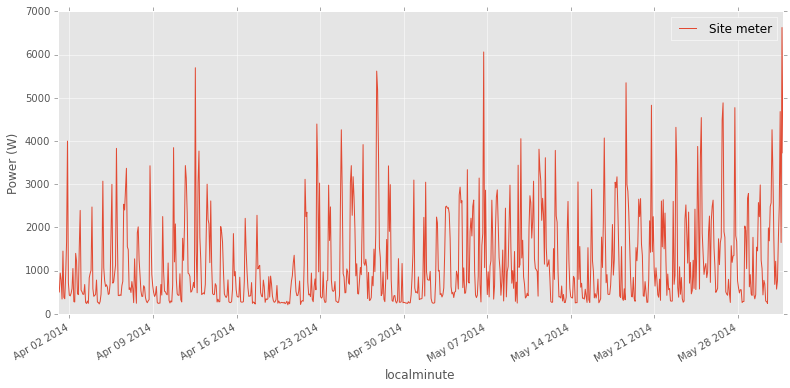

In [6]:
train.buildings[1].elec.mains().plot()

### Let's split data at April 30th

In [7]:
train.set_window(end="30-4-2014")
test.set_window(start="30-4-2014")

In [8]:
train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

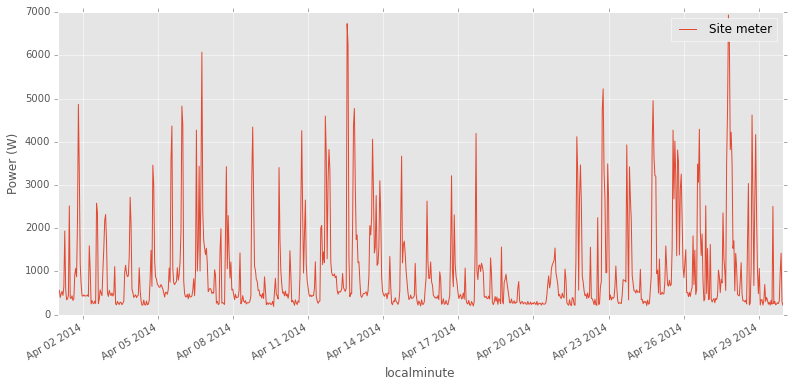

In [9]:
train_elec.mains().plot()

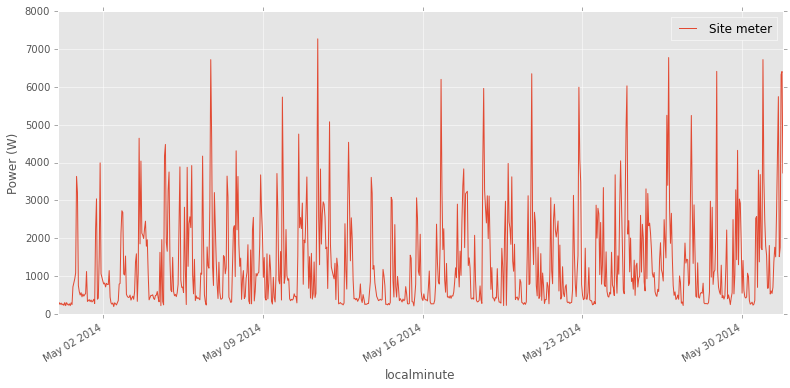

In [10]:
test_elec.mains().plot()

In [11]:
top_2_train_elec = train_elec.submeters().select_top_k(k=2)

15/15 ElecMeter(instance=16, building=1, dataset='WikiEnergy', appliances=[Appliance(type='appliance', instance=1)])

In [12]:
top_2_train_elec

MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='WikiEnergy', appliances=[Appliance(type='electric vehicle', instance=1)])
  ElecMeter(instance=2, building=1, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])
)

In [13]:
test_mains_df = test_elec.mains().load().next()

In [14]:
from nilmtk.disaggregate import Hart85
h = Hart85()

In [15]:
h.train(train_elec.mains())

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


In [19]:
from nilmtk.feature_detectors.steady_states import find_steady_states_transients, find_steady_states
[_, transients] = find_steady_states(test_mains_df, h.cols, h.state_threshold, h.noise_level)

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


In [21]:
hart_pred_df = h.disaggregate_single_chunk(test_mains_df, {}, transients )

In [22]:
hart_pred_df[[0]].head()

,0
localminute,
2014-04-30 00:00:00-05:00,0
2014-04-30 00:01:00-05:00,0
2014-04-30 00:02:00-05:00,0
2014-04-30 00:03:00-05:00,120
2014-04-30 00:04:00-05:00,120


In [23]:
disag_filename = '/Users/nipunbatra/Desktop/test_hart.h5'
output = HDFDataStore(disag_filename, 'w')
h.disaggregate(test_elec.mains(), output, sample_period=60)
output.close()
disag = DataSet(disag_filename)
disag_elec = disag.buildings[building_number].elec

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


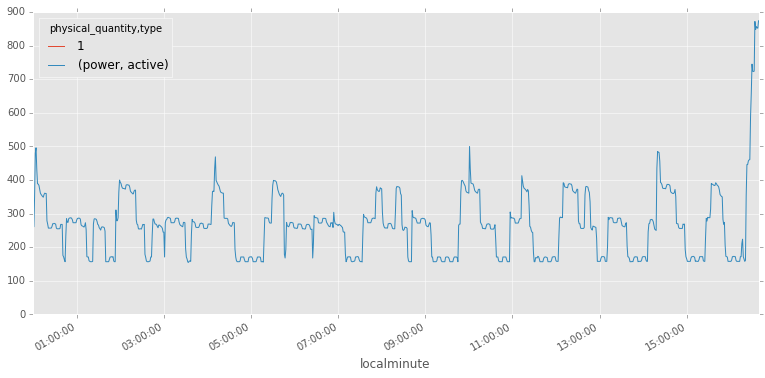

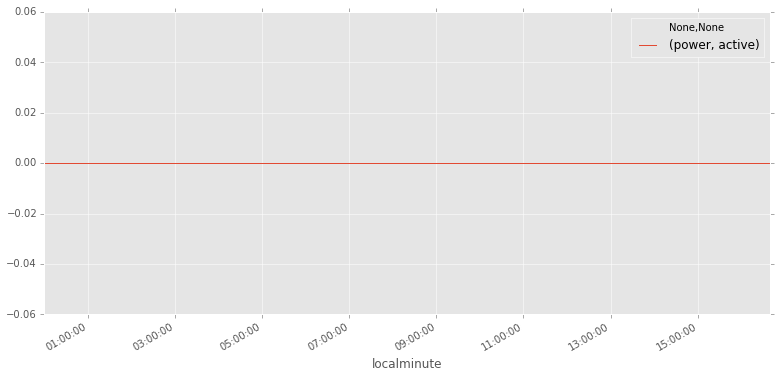

In [27]:
ax = hart_pred_df[[1]].head(1000).plot()
test_mains_df.head(1000).plot(ax=ax)
disag_elec[('unknown', 1)].load().next().head(1000).plot()

In [ ]:
start=time.time()
fhmm = fhmm_exact.FHMM()
fhmm.train(top_2_train_elec, sample_period=60)
end=time.time()
print end-start

In [ ]:
fhmm.disaggregate_chunk(test_mains_df).head()

In [ ]:
from nilmtk.disaggregate import CombinatorialOptimisation

In [ ]:
co = CombinatorialOptimisation()

In [ ]:
co.train(top_2_train_elec, sample_period=60)



In [ ]:
pred_df = co.disaggregate_chunk(test_mains_df)

In [ ]:
co.model

In [ ]:
co.model[0]['training_metadata']

In [ ]:
[co.model[i]['training_metadata'] for i in pred_df.columns]

In [ ]:
pred_df.columns = [co.model[i]['training_metadata'] for i in pred_df.columns]

In [ ]:
pred_df.head()

In [ ]:
h = Hart85()

In [ ]:
from nilmtk.feature_detectors.steady_states import find_steady_states_transients, find_steady_states
[_, transients] = find_steady_states(test_mains_df, h.cols, h.state_threshold, h.noise_level)

In [ ]:
hart_pred_df.head()

In [ ]:
h.centroids.index.values

In [ ]:
hart_pred_df.head()

In [ ]:
chunk = test_elec.mains().power_series().next()

In [ ]:
cols = pd.MultiIndex.from_tuples([chunk.name])

In [ ]:
cols

In [ ]:
meter = 0

In [ ]:
df = hart_pred_df[[meter]]

In [ ]:
df.columns = cols

In [ ]:
df

In [ ]:
disag_elec

In [ ]:
disag_elec.plot()

In [ ]:
st = pd.HDFStore(disag_filename)

In [ ]:
d = disag_elec[('unknown',0)].load().next()

In [ ]:
d.tail()

In [ ]:
hart_pred_df[[0]].tail()

In [ ]:
f1 = f1_score(disag_elec, test_elec)
f1.index = disag_elec.get_labels(f1.index)
f1.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("FHMM");

In [ ]:
# CSS styling
from IPython.core.display import display, HTML
display(HTML(open('static/styles.css', 'r').read()));